In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import statistics 
import math
import folium
from geopy.geocoders import ArcGIS
from st_dbscan import ST_DBSCAN
import geopy.distance
import statsmodels.api as sm
import seaborn as sns

# import model and matrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score

# packages utiles
from sklearn import svm
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score




import data_prep as dp

In [ ]:
df_fix = pd.read_csv("C:/Users/t480/Desktop/University courses/ENSAE 2A/STATAPP/Statapp-Hail-storm/bdd.csv")

In [ ]:
def convert_time_to_timestamps(df):
    df['TIME_EVENT'] = pd.to_datetime(df['TIME_EVENT'],format = '%Y-%m-%d %H:%M:%S')
    df['TIME_EVENT'] = df.TIME_EVENT.values.astype(np.float64) # in nanoseconds
    df.TIME_EVENT = df.TIME_EVENT / (10 ** 9) # in seconds 
    df.TIME_EVENT = df.TIME_EVENT / 3600 # in hours
    return df

In [ ]:
def convert_timestamps_to_date(df):
    new_df = df
    new_df.TIME_EVENT = new_df.TIME_EVENT * (10 ** 9)  
    new_df.TIME_EVENT = new_df.TIME_EVENT * 3600
    new_df.TIME_EVENT = pd.to_datetime(new_df.TIME_EVENT, format='%Y-%m-%d %H:%M:%S')#.dt.time
    return new_df

In [ ]:
def getting_ready(df, country, year_since):
    df = convert_time_to_timestamps(df)
    df = df[df['COUNTRY'] == country]
    df = df[df['YEAR'] >= year_since]
    df = df[['TIME_EVENT', 'LATITUDE', 'LONGITUDE']]
    df = df.reset_index(drop=True)
    return df 

In [ ]:
def run_dbscan_retrieve_classes(df, spatial_th, time_th, min_sample):
    model = ST_DBSCAN(eps1=spatial_th, eps2=time_th, min_samples=min_sample)
    fit = model.fit(df) 
    labels = pd.DataFrame(model.labels)
    df['LABELS'] = labels
    return df

Visualising the timing of reports with an intensity map 

In [ ]:
def visualise_biggest(df, n_biggest):

    nb_reports = pd.DataFrame(df['LABELS'].value_counts()).reset_index()
    nb_reports = nb_reports[nb_reports['index'] != -1].sort_values('LABELS', ascending=False).reset_index()
    labels_biggest_storms = list(nb_reports.iloc[0:n_biggest,1])
    df_biggest = df.loc[df.LABELS.isin(labels_biggest_storms)]

    # plots the n_biggest storms 
    plt.figure(figsize=(10,6))
    for i in range(n_biggest):
        a = df_biggest.LONGITUDE[df_biggest.LABELS == labels_biggest_storms[i]]
        b = df_biggest.LATITUDE[df_biggest.LABELS == labels_biggest_storms[i]]
        lab = df_biggest.loc[df_biggest.LABELS == labels_biggest_storms[i]]
        plt.scatter(a, b, c='C{}'.format(i), label='{} most reported storm'.format(i+1))
    plt.ylabel('latitude')
    plt.xlabel('longitude')
    plt.legend()
    plt.title("The {} biggest storms in terms of report counts".format(len(labels_biggest_storms)))
    plt.show()

    # plot timing of storms in latlon
    for i in range(n_biggest):
        x = df_biggest.LONGITUDE[df_biggest.LABELS == labels_biggest_storms[i]]
        y = df_biggest.LATITUDE[df_biggest.LABELS == labels_biggest_storms[i]]
        z = df_biggest.TIME_EVENT[df_biggest.LABELS == labels_biggest_storms[i]]
        z = z - z.iloc[-1]
        x = x.array
        y = y.array
        z = z.array
        axis = plt.subplot(111, title="Storm with {} reports".format(len(x)))
        sc = axis.scatter(x, y, c=z, marker=".")
        plt.colorbar(sc, label="duration of the storm (in hours)")
        plt.show()

        # distance between first and last reports
        df_distance = df_biggest[df_biggest.LABELS==labels_biggest_storms[i]].sort_values('TIME_EVENT')
        df_distance = df_distance.reset_index(drop=True)
        latbegin = df_distance.LATITUDE[0]
        latend = df_distance.LATITUDE[len(df_distance.LATITUDE)-1]
        lonbegin = df_distance.LONGITUDE[0]
        lonend = df_distance.LONGITUDE[len(df_distance.LONGITUDE)-1]
        coords_1 = (latbegin, lonbegin)
        coords_2 = (latend, lonend)
        dist = geopy.distance.geodesic(coords_1, coords_2).km
        print("The storm has length",dist,"km between first report and last report")
        
        # date of first report of storms
        df_date = convert_timestamps_to_date(df_distance)
        date = df_distance.TIME_EVENT[0]
        print("The storm took place on",date)


    return df#, df_biggest 

PREP DEMOG DATA

In [ ]:
communes_latlon = pd.read_csv("C:/Users/t480/statappradar/communes-departement-region latlon.csv")
communes_densite = pd.read_excel("C:/Users/t480/statappradar/densite communes.xlsx")
communes_latlon
communes_latlon = communes_latlon[['code_commune_INSEE','nom_commune_complet','latitude','longitude']]
communes_latlon = communes_latlon.dropna()
communes_latlon = communes_latlon[~communes_latlon.code_commune_INSEE.str.startswith('97')]
communes_latlon = communes_latlon[~communes_latlon.code_commune_INSEE.str.startswith('2A')]
communes_latlon = communes_latlon[~communes_latlon.code_commune_INSEE.str.startswith('2B')]
communes_latlon['code_commune_INSEE'] = pd.to_numeric(communes_latlon['code_commune_INSEE'])
#communes_latlon['code_commune_INSEE'] = communes_latlon['code_commune_INSEE'].astype(int)
communes_latlon = communes_latlon.rename(columns = {'nom_commune_complet':'Libellé'})
communes_latlon
type(communes_latlon.iloc[0,0])
communes_densite
communes_densite = communes_densite[~communes_densite.Code.str.startswith('97')]
communes_densite = communes_densite[~communes_densite.Code.str.startswith('2A')]
communes_densite = communes_densite[~communes_densite.Code.str.startswith('2B')]
communes_densite['Code'] = pd.to_numeric(communes_densite['Code'])
communes_densite = communes_densite.rename(columns = {'Code':'code_commune_INSEE'})
communes_densite

dense = pd.read_excel("C:/Users/t480/statappradar/INSEE densite communes float.xlsx")
dense
dense = dense[['codgeo','libgeo','dens_pop']]
dense = dense[~dense.codgeo.str.startswith('97')]
dense = dense[~dense.codgeo.str.startswith('2A')]
dense = dense[~dense.codgeo.str.startswith('2B')]
dense['codgeo'] = pd.to_numeric(dense['codgeo'])
dense = dense.rename(columns = {'codgeo':'code_commune_INSEE'})
dense

communes = pd.merge(communes_latlon, dense,how='inner', on='code_commune_INSEE')
communes = communes.drop(columns=['libgeo'])
communes = communes.rename(columns = {'Libellé':'PLACE'})
communes = communes.drop_duplicates()
#communes['PLACE'].value_counts().head(15)
#communes.loc[communes['PLACE'] == "Livarot-Pays-d'Auge", :]
communes

communes.to_csv("C:/Users/t480/statappradar/communes.csv")
#Preparing data for the logistic regression
data = pd.read_csv("C:/Users/t480/statappradar/eswd_reports_europe_1970_2022.csv")
df=data.drop(['CONTACT','EMAIL', 'ORGANISATION', 'ORGANISATION_ID','CREATOR_ID','REVISOR_ID','PERSON_REVISION','PLACE_LOCAL_LANGUAGE','OROGRAPHY','SURFACE_INITIAL_LOCATION','SURFACE_CROSSED','NO_OBJECTS','EXT_URL','LINK_ORG','LINK_ID','DELETED','F_SCALE','T_SCALE','RATING_BASIS','WIND_SPEED','TEN_MIN_WIND_SPEED','FUNNEL_SIGHTED'  ,'SUCTION_VORTICES' ,'PRECIPITATION_AMOUNT','SNOW_FALL_AMOUNT','PEAK_PRECIP_AMOUNT','PEAK_SNOW_FALL_AMOUNT','PEAK_PRECIP_PERIOD','MAX_6_HOUR_PRECIP','MAX_6_HOUR_SNOW_FALL','MAX_12_HOUR_PRECIP','MAX_12_HOUR_SNOW_FALL','MAX_24_HOUR_PRECIP' ,'MAX_24_HOUR_SNOW_FALL','TYPE_PRECIP','SIZE_ACCOMPANYING_HAIL','POSSIBILITIES','PATH_LENGTH','MEAN_PATH_WIDTH','MAX_PATH_WIDTH','MAX_VERTICAL_DEVELOP','DIRECTION_MOVEMENT','SNOW_HAZARDS','MEAN_HEIGHT_SNOW_CORNICES','MAX_HEIGHT_SNOW_CORNICES','ICE_HAZARDS','THICKNESS_ICE_COVER','THICKNESS_RIME_COVER','AVALANCHE_TYPE','AVALANCHE_FLOW_TYPE','SNOW_MASS_TYPE','AVALANCHE_SIZE','AVALANCHE_TRIGGER','ELEVATION_START','ELEVATION_DIFFERENCE','LIGHTNING_DAMAGE_TO','PEAK_CURRENT','POLARITY','TIME_CREATION','TIME_LAST_REVISION','DETAILED_LOCATION','MAX_HAILSTONE_WEIGHT','CONVECTIVE','PATH_START_LATITUDE','PATH_START_LONGITUDE','PATH_START_DATETIME','PATH_END_LATITUDE','PATH_END_LONGITUDE','PATH_END_DATETIME'],axis=1)

# function allowing us to extract the year from the date of the event
def get_year(donnee):
    date=donnee['TIME_EVENT']
    dt=datetime.strptime(date,'%Y-%m-%d %H:%M:%S')
    dt=dt.year
    return dt

# creation of a column containing the year of the event
df['YEAR']=df.apply(lambda donnee: get_year(donnee), axis=1)

# deleting data prior to 2007 
df.drop(df[df.YEAR < 2007].index, inplace=True)

# function allowing us to extract the month from the date of the event
def get_month(donnee):
    date=donnee['TIME_EVENT']
    dt=datetime.strptime(date,'%Y-%m-%d %H:%M:%S')
    dt=dt.month
    return dt

# creation of a column containing the month of the event
df['MONTH']=df.apply(lambda donnee: get_month(donnee), axis=1)

# function allowing us to extract the day from the date of the event
def get_day(donnee):
    date=donnee['TIME_EVENT']
    dt=datetime.strptime(date,'%Y-%m-%d %H:%M:%S')
    dt=dt.day
    return dt

# creation of a column containing the month of the event
df['DAY']=df.apply(lambda donnee: get_day(donnee), axis=1)

# function allowing us to extract the hour from the date of the event
def get_hour(donnee):
    date=donnee['TIME_EVENT']
    dt=datetime.strptime(date,'%Y-%m-%d %H:%M:%S')
    dt=dt.hour
    return dt

# creation of a column containing the month of the event
df['HOUR']=df.apply(lambda donnee: get_hour(donnee), axis=1)

#maintaining only the columns needed for our model
df=df.loc[:,['LATITUDE','LONGITUDE','TIME_EVENT','COUNTRY','PLACE', 'YEAR', 'MAX_HAIL_DIAMETER']]
#df=df.loc[:,['LATITUDE','LONGITUDE','TIME_EVENT','COUNTRY','YEAR', 'MONTH', 'HOUR','PLACE', 'MAX_HAIL_DIAMETER']]

# delete data prior to 2013 
#(radar data provided to us only start from 2013, we wont be able to confront data prior to that year)
df.drop(df[df.YEAR < 2013].index, inplace=True)
df=df.loc[:,['LATITUDE','LONGITUDE','TIME_EVENT','COUNTRY','PLACE', 'MAX_HAIL_DIAMETER']]

# selecting France and converting to timestamps
df = convert_time_to_timestamps(df)
df = df.reset_index(drop=True)
country = 'FR'
df = df[df['COUNTRY'] == country]

# filtering on mainland France
#print(df_mainland_fr.LATITUDE.max(), df_mainland_fr.LATITUDE.min(), df_mainland_fr.LONGITUDE.max(), df_mainland_fr.LONGITUDE.min(),
# communes.latitude.max(), communes.latitude.min(), communes.longitude.max(), communes.longitude.min())
df.drop(df[df.LATITUDE > communes.latitude.max()].index, inplace=True)
df.drop(df[df.LATITUDE < communes.latitude.min()].index, inplace=True)
df.drop(df[df.LONGITUDE > communes.longitude.max()].index, inplace=True)
df.drop(df[df.LONGITUDE < communes.longitude.min()].index, inplace=True)

nom=ArcGIS()
nom.geocode("Monaco") 
#43.73170451200008, 7.424355000000048
df = df.drop(df[(df.LATITUDE < 43.73170451200008) & (df.LONGITUDE > 7.424355000000048)].index)

df_mainland_fr = df 
df_mainland_fr

df_density = communes.loc[:,['dens_pop','PLACE']]
df_mainland_fr = pd.merge(df_mainland_fr, df_density,how='inner', on='PLACE')
print(df_mainland_fr.LATITUDE.max(), df_mainland_fr.LATITUDE.min(), df_mainland_fr.LONGITUDE.max(), df_mainland_fr.LONGITUDE.min(),
 communes.latitude.max(), communes.latitude.min(), communes.longitude.max(), communes.longitude.min())

df_dbscan = df_mainland_fr[['TIME_EVENT', 'LATITUDE', 'LONGITUDE']]
df_dbscan = df_dbscan.reset_index(drop=True)
df_dbscan = run_dbscan_retrieve_classes(df_dbscan, 0.16, 1, 2)
df_mainland_fr['LABEL'] = df_dbscan.loc[:,'LABELS']

dfreg = df_mainland_fr[df_mainland_fr.LABEL > -1]
dfreg = dfreg.drop(columns=['COUNTRY','PLACE'])

dummies = pd.get_dummies(dfreg['LABEL'])
dummies
dfreg = dfreg.join(dummies)

dfreg

C:\Users\t480\AppData\Local\Temp\ipykernel_17168\2626580170.py:42: DtypeWarning: Columns (18,22,23,24,50,51,77,78,79,85,88) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("C:/Users/t480/statappradar/eswd_reports_europe_1970_2022.csv")


51.05 42.433 8.133 -3.95 51.0730436867 42.3559782284 8.18637725776 -5.08534533544


,LATITUDE,LONGITUDE,TIME_EVENT,MAX_HAIL_DIAMETER,dens_pop,LABEL,0,1,2,3,...,411,412,413,414,415,416,417,418,419,420
0,45.567,5.933,462946.250000,2.0,2802.91,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,45.567,5.933,452126.750000,2.0,2802.91,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,45.596,5.875,462945.866667,2.0,399.73,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,49.583,1.358,462928.500000,4.5,27.09,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,49.583,1.358,462928.500000,4.5,107.41,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3230,47.284,2.954,380728.000000,NaN,79.93,419,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3232,47.317,2.967,380728.000000,NaN,27.03,419,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3234,47.983,6.750,379861.250000,2.0,63.15,420,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3235,47.933,6.667,379861.083333,4.0,77.45,420,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
df = df_fix.copy()
country = 'FR'
year_since = 2022
df = getting_ready(df, country, year_since)
df

,TIME_EVENT,LATITUDE,LONGITUDE
0,462946.250000,45.567,5.933
1,462945.866667,45.596,5.875
2,462928.500000,49.583,1.358
3,462928.416667,49.533,1.267
4,462928.383333,49.521,1.251
...,...,...,...
1975,458531.666667,43.279,2.460
1976,458514.500000,44.600,-0.933
1977,458174.283333,48.669,5.114
1978,458174.166667,48.636,4.952


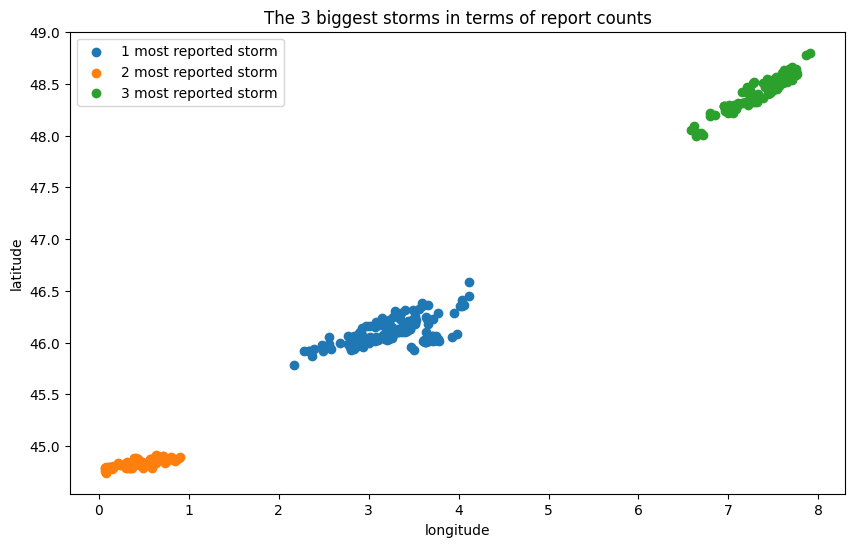

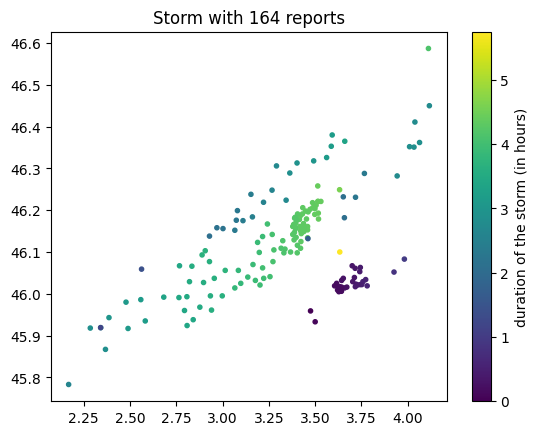

The storm has length 19.881225425338197 km between first report and last report
The storm took place on 2022-06-04 16:10:00


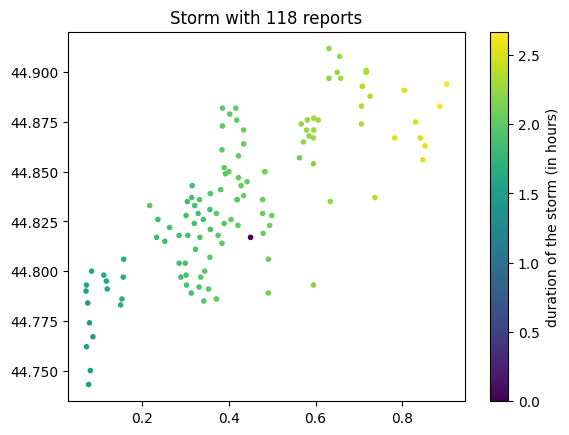

The storm has length 36.815461341171435 km between first report and last report
The storm took place on 2022-06-02 02:30:00


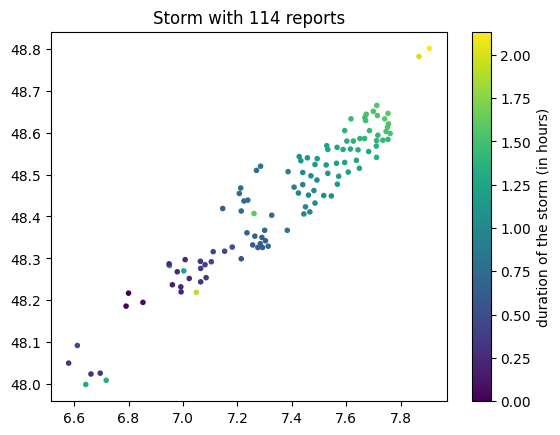

The storm has length 104.32207762462204 km between first report and last report
The storm took place on 2022-06-26 18:47:00


,TIME_EVENT,LATITUDE,LONGITUDE,LABELS
0,462946.250000,45.567,5.933,0
1,462945.866667,45.596,5.875,0
2,462928.500000,49.583,1.358,1
3,462928.416667,49.533,1.267,1
4,462928.383333,49.521,1.251,1
...,...,...,...,...
1975,458531.666667,43.279,2.460,158
1976,458514.500000,44.600,-0.933,-1
1977,458174.283333,48.669,5.114,159
1978,458174.166667,48.636,4.952,159


In [ ]:
df1 = run_dbscan_retrieve_classes(df, 0.2, 2, 2)
visualise_biggest(df1,3)

In [ ]:
df_date = convert_timestamps_to_date(df1)
df_date

,TIME_EVENT,LATITUDE,LONGITUDE,LABELS
0,2022-10-24 10:15:00.000000000,45.567,5.933,0
1,2022-10-24 09:51:59.999999744,45.596,5.875,0
2,2022-10-23 16:30:00.000000000,49.583,1.358,1
3,2022-10-23 16:25:00.000000000,49.533,1.267,1
4,2022-10-23 16:23:00.000000256,49.521,1.251,1
...,...,...,...,...
1975,2022-04-23 11:40:00.000000000,43.279,2.460,158
1976,2022-04-22 18:30:00.000000000,44.600,-0.933,-1
1977,2022-04-08 14:17:00.000000000,48.669,5.114,159
1978,2022-04-08 14:10:00.000000000,48.636,4.952,159


In [ ]:
df_date

,TIME_EVENT,LATITUDE,LONGITUDE,LABELS
0,2022-10-24 10:15:00.000000000,45.567,5.933,0
1,2022-10-24 09:51:59.999999744,45.596,5.875,0
2,2022-10-23 16:30:00.000000000,49.583,1.358,1
3,2022-10-23 16:25:00.000000000,49.533,1.267,1
4,2022-10-23 16:23:00.000000256,49.521,1.251,1
...,...,...,...,...
1975,2022-04-23 11:40:00.000000000,43.279,2.460,158
1976,2022-04-22 18:30:00.000000000,44.600,-0.933,-1
1977,2022-04-08 14:17:00.000000000,48.669,5.114,159
1978,2022-04-08 14:10:00.000000000,48.636,4.952,159


In [ ]:
#varying spatial threshold
#for i in np.arange(0.01,0.3,0.03):
#    visualise_biggest(run_dbscan_retrieve_classes(df, i, 2, 2),3)
#    print("Spatial threshold is",i)



donnees demog

In [ ]:
database = pd.read_csv("C:/Users/t480/Desktop/University courses/ENSAE 2A/STATAPP/Statapp-Hail-storm/bdd.csv")

In [ ]:
database

,Unnamed: 0,LATITUDE,LONGITUDE,TIME_EVENT,COUNTRY,YEAR
0,0,45.567,5.933,2022-10-24 10:15:00,FR,2022
1,1,45.596,5.875,2022-10-24 09:52:00,FR,2022
2,2,50.967,2.667,2022-10-23 17:00:00,BE,2022
3,3,51.000,2.700,2022-10-23 17:00:00,BE,2022
4,4,49.583,1.358,2022-10-23 16:30:00,FR,2022
...,...,...,...,...,...,...
33633,33633,36.938,14.410,2013-01-15 06:30:00,IT,2013
33634,33634,36.948,14.435,2013-01-15 06:30:00,IT,2013
33635,33635,36.918,14.415,2013-01-15 06:30:00,IT,2013
33636,33636,36.954,14.533,2013-01-15 06:15:00,IT,2013


In [ ]:
data_demog = pd.read_excel("C:/Users/t480/Desktop/University courses/ENSAE 2A/STATAPP/Statapp-Hail-storm/data demog.xlsx")

In [ ]:
data_demog

,Insee - Statistiques locales,Unnamed: 1,Unnamed: 2
0,Référentiel géographique : France par commune,NaN,NaN
1,NaN,NaN,Indic1
2,Code,Libellé,Population municipale 2020
3,01001,L'Abergement-Clémenciat,806
4,01002,L'Abergement-de-Varey,262
...,...,...,...
34953,97613,M'Tsangamouji,N/A - résultat non disponible
34954,97614,Ouangani,N/A - résultat non disponible
34955,97615,Pamandzi,N/A - résultat non disponible
34956,97616,Sada,N/A - résultat non disponible


In [ ]:
database.columns


Index(['Unnamed: 0', 'LATITUDE', 'LONGITUDE', 'TIME_EVENT', 'COUNTRY', 'YEAR'], dtype='object')

In [ ]:
data_demog = data_demog.rename(columns = {'Insee - Statistiques locales':'POSTCODE', 'Unnamed: 1':'PLACE', 'Unnamed: 2':'POPULATION'})
data_demog = data_demog.iloc[3:-1]

In [ ]:
data_demog

,POSTCODE,PLACE,POPULATION
3,01001,L'Abergement-Clémenciat,806
4,01002,L'Abergement-de-Varey,262
5,01004,Ambérieu-en-Bugey,14288
6,01005,Ambérieux-en-Dombes,1782
7,01006,Ambléon,113
...,...,...,...
34952,97612,Mtsamboro,N/A - résultat non disponible
34953,97613,M'Tsangamouji,N/A - résultat non disponible
34954,97614,Ouangani,N/A - résultat non disponible
34955,97615,Pamandzi,N/A - résultat non disponible


In [ ]:
# cannot merge our data with data from insee since there is a lot of cities that will not have a track.
# we need the latitude and longitude of each cities in the insee data
# need to study the shape of storms, if it is a rectangle, that is rather straight, 
# with some depending thickness, then we can start to infer movements
# say we have two clusters and they are in a rectangle, but in the middle there is no track
# then it may be the same storm. 
# we can compute an average reporting rate, then multiply with the population in the cities where no tracks appear
# if this expected number of reports is lower than a threshold, it may be the two clusters 
# represent only one storm
# we also need to inspect a few KM ahead and after the cluster, whether or not another cluster may be related 
# this is to observe formation and death of each storm, that may be less intense zones but still 
# important to study : time to reach peak activity for example

We want to investigate whether we miss-detect the area of the storm because some regions are not populated 

compute rate of report 

In [ ]:
# idea of algorithm 
# we run dbscan with restrictive parameters,
# then for each cluster, we take the cities in the rectangle and we compute their expected nb of reports 
# if the figure is above the threshold we keep it as is
# but if it is below, we run dbscan with less restrictive parameters on a subset of obs
# in particular we delete all observations not in the trajectory 
# (the rectangle, with an arbitrarily big length and width) and that are not timely coherent 


DEMOG

In [ ]:
dfgeo = pd.read_csv("C:/Users/t480/statappradar/events+demog_france.csv")

In [ ]:
dfgeo 

,Unnamed: 0,LATITUDE,LONGITUDE,TIME_EVENT,COUNTRY,YEAR,NEAREST_CITY,Population municipale 2020
0,0,45.567,5.933,2022-10-24 10:15:00,FR,2022,Barberaz,5167
1,1,45.596,5.875,2022-10-24 09:52:00,FR,2022,La Motte-Servolex,12377
2,2,49.583,1.358,2022-10-23 16:30:00,FR,2022,Buchy,2820
3,3,49.533,1.267,2022-10-23 16:25:00,FR,2022,Buchy,2820
4,4,49.521,1.251,2022-10-23 16:23:00,FR,2022,Isneauville,3601
...,...,...,...,...,...,...,...,...
3235,3235,47.150,6.350,2013-05-01 12:15:00,FR,2013,Valdahon,5734
3236,3236,44.850,0.483,2013-05-01 03:30:00,FR,2013,Bergerac,26360
3237,3237,44.868,0.522,2013-05-01 03:30:00,FR,2013,Creysse,1751
3238,3238,44.883,0.533,2013-05-01 03:30:00,FR,2013,Creysse,1751


In [ ]:
database = pd.read_csv("C:/Users/t480/statappradar/database.csv")

In [ ]:
database_fr = database[database['COUNTRY']=='FR']
database_fr = database_fr[database_fr['YEAR']== 2022] 

In [ ]:
database_fr

,Unnamed: 0,LATITUDE,LONGITUDE,TIME_EVENT,COUNTRY,YEAR,PLACE
0,0,45.567,5.933,2022-10-24 10:15:00,FR,2022,Chambéry
1,1,45.596,5.875,2022-10-24 09:52:00,FR,2022,La Motte-Servolex
4,4,49.583,1.358,2022-10-23 16:30:00,FR,2022,Buchy
5,5,49.533,1.267,2022-10-23 16:25:00,FR,2022,Bierville
6,6,49.521,1.251,2022-10-23 16:23:00,FR,2022,Morgny-la-Pommeraye
...,...,...,...,...,...,...,...
7274,7274,43.279,2.460,2022-04-23 11:40:00,FR,2022,Villarzel-Cabardès
7275,7275,44.600,-0.933,2022-04-22 18:30:00,FR,2022,Mios
7308,7308,48.669,5.114,2022-04-08 14:17:00,FR,2022,Rupt-aux-Nonains
7309,7309,48.636,4.952,2022-04-08 14:10:00,FR,2022,Saint-Dizier


In [ ]:
import folium
from geopy.geocoders import ArcGIS

In [ ]:
nom=ArcGIS()
nom.geocode("France")
map=folium.Map(location=[46.55941704400004, 2.5505399530000545])
#map

In [ ]:
map_new=folium.Map()
list_coor=dfgeo[['NEAREST_CITY','LATITUDE','LONGITUDE']].values.tolist()
for i in list_coor:
    map_new.add_child(folium.Marker(location=[i[1],i[2]],
                                popup=i[0],icon=folium.Icon(color='green')))
#map_new#.save('tiger_reserve_new.html')

In [ ]:
map_new=folium.Map()
list_coor=database_fr[['PLACE','LATITUDE','LONGITUDE']].values.tolist()
for i in list_coor:
    map_new.add_child(folium.Marker(location=[i[1],i[2]],
                                popup=i[0],icon=folium.Icon(color='green')))
#map_new#.save('tiger_reserve_new.html')

FUNCTION TO IDENTIFY CLOSE CLUSTERS

In [ ]:
# # all storms are well-behaved
df2 = run_dbscan_retrieve_classes(df, 0.1, 1, 2)
visualise_biggest(df2,6) 

TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[int64]'>)

In [ ]:
# all storms are well-behaved temporally but some storms may be merged
df3 = run_dbscan_retrieve_classes(df, 0.1, 1, 2)
visualise_biggest(df3,10) 

TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[int64]'>)

In [ ]:
df3

,TIME_EVENT,LATITUDE,LONGITUDE,LABELS
0,462946.250000,45.567,5.933,0
1,462945.866667,45.596,5.875,0
2,462928.500000,49.583,1.358,-1
3,462928.416667,49.533,1.267,1
4,462928.383333,49.521,1.251,1
...,...,...,...,...
1975,458531.666667,43.279,2.460,234
1976,458514.500000,44.600,-0.933,-1
1977,458174.283333,48.669,5.114,235
1978,458174.166667,48.636,4.952,235


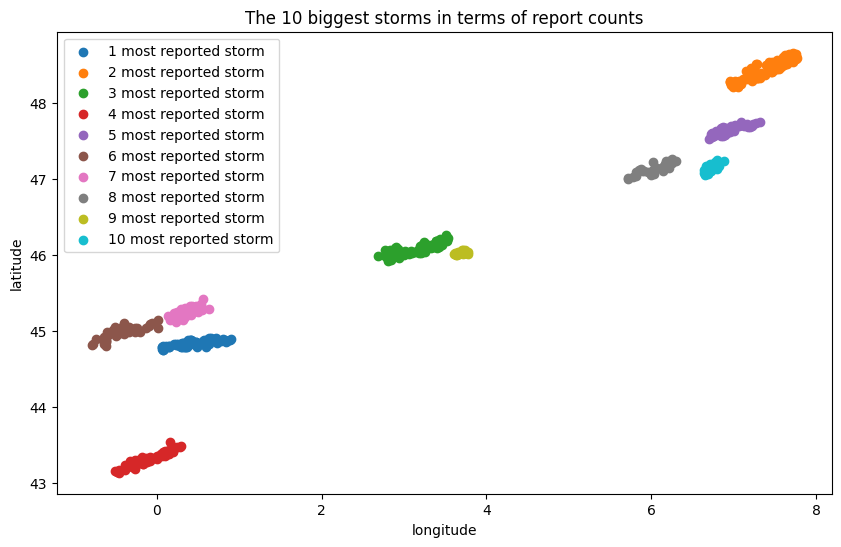

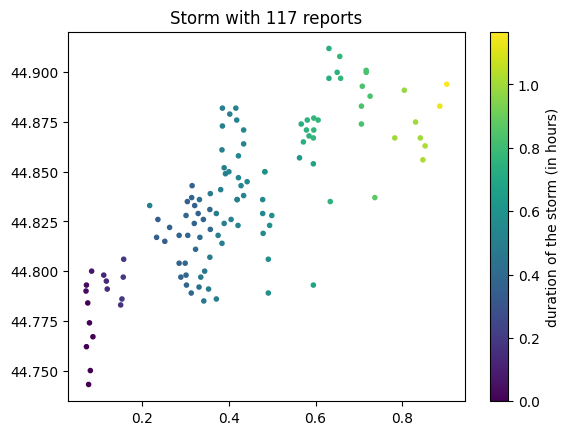

The storm has length 67.52959590342743 km between first report and last report
The storm took place on 2022-06-02 04:00:00


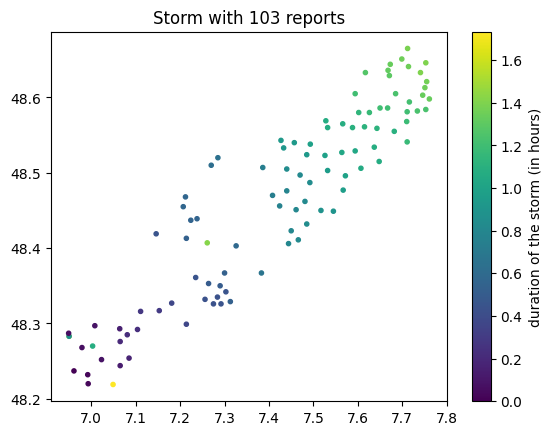

The storm has length 6.8375452025767975 km between first report and last report
The storm took place on 2022-06-26 18:58:00


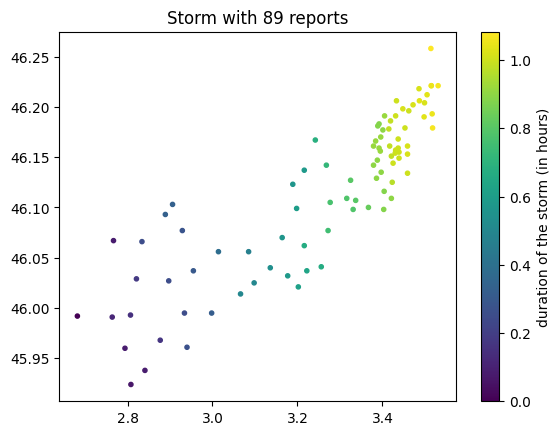

The storm has length 70.77541793306861 km between first report and last report
The storm took place on 2022-06-04 19:30:00


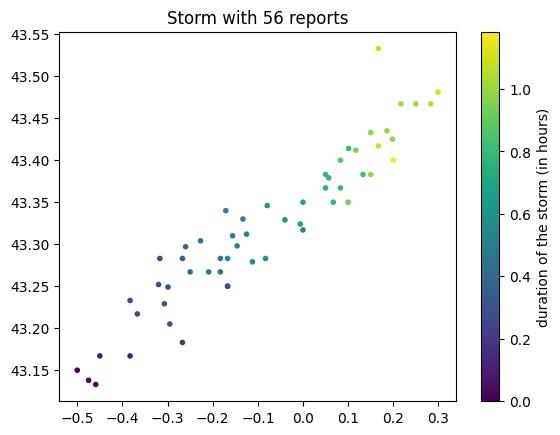

The storm has length 63.24786707277645 km between first report and last report
The storm took place on 2022-06-20 18:44:00


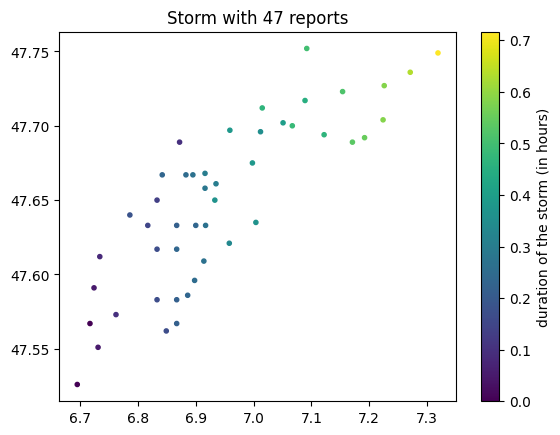

The storm has length 53.04266115230942 km between first report and last report
The storm took place on 2022-06-26 20:21:59.999999744


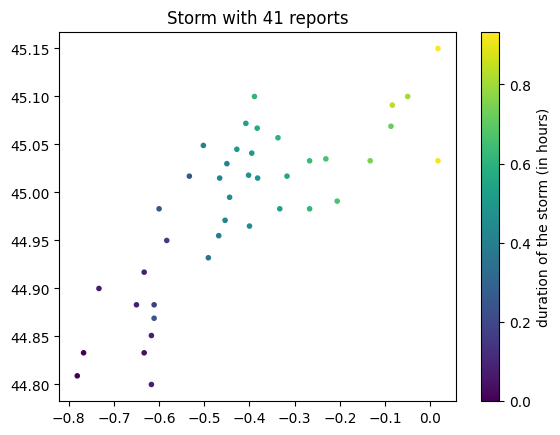

The storm has length 73.46927409221279 km between first report and last report
The storm took place on 2022-06-20 19:05:00


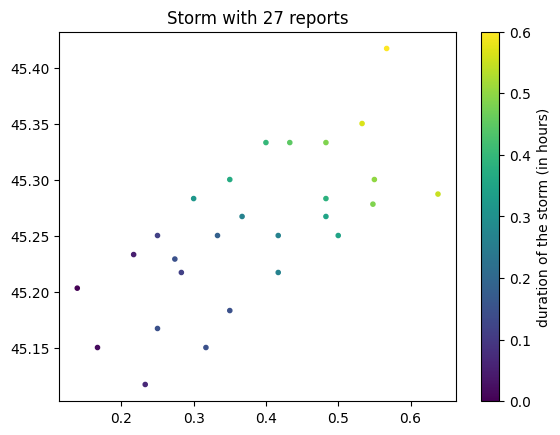

The storm has length 41.136203675462355 km between first report and last report
The storm took place on 2022-06-20 20:09:00


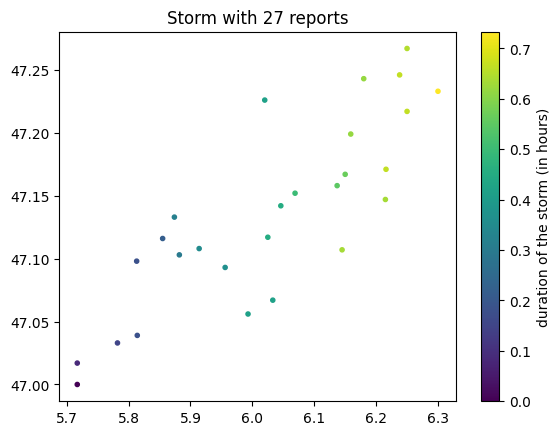

The storm has length 51.26898233914196 km between first report and last report
The storm took place on 2022-06-26 20:25:00


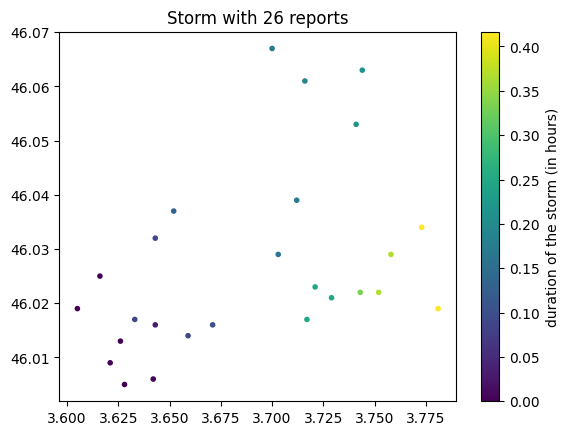

The storm has length 11.619154894308494 km between first report and last report
The storm took place on 2022-06-04 16:20:00


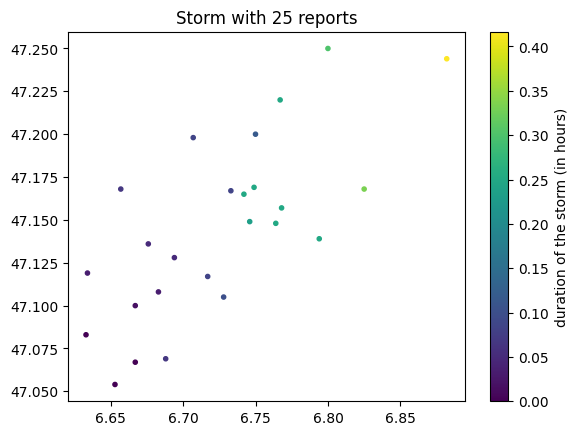

The storm has length 27.346655930039102 km between first report and last report
The storm took place on 2022-07-20 14:30:00


,TIME_EVENT,LATITUDE,LONGITUDE,LABELS
0,462946.250000,45.567,5.933,0
1,462945.866667,45.596,5.875,0
2,462928.500000,49.583,1.358,-1
3,462928.416667,49.533,1.267,1
4,462928.383333,49.521,1.251,1
...,...,...,...,...
1975,458531.666667,43.279,2.460,223
1976,458514.500000,44.600,-0.933,-1
1977,458174.283333,48.669,5.114,-1
1978,458174.166667,48.636,4.952,-1


In [ ]:
# all storms are well-behaved, not bad as merges storms
df7 = run_dbscan_retrieve_classes(df, 0.15, 1, 2)
visualise_biggest(df7,10) 

In [ ]:
df_facts = df7[df7.LABELS > -1]

In [ ]:
labels = df_facts['LABELS'].value_counts()
labels

161    117
60     106
127     98
98      73
99      57
      ... 
126      2
36       2
122      2
119      2
0        2
Name: LABELS, Length: 191, dtype: int64

(array([157.,  21.,   6.,   2.,   1.,   0.,   1.,   0.,   1.,   2.]),
 array([  2. ,  13.5,  25. ,  36.5,  48. ,  59.5,  71. ,  82.5,  94. ,
        105.5, 117. ]),
 <BarContainer object of 10 artists>)

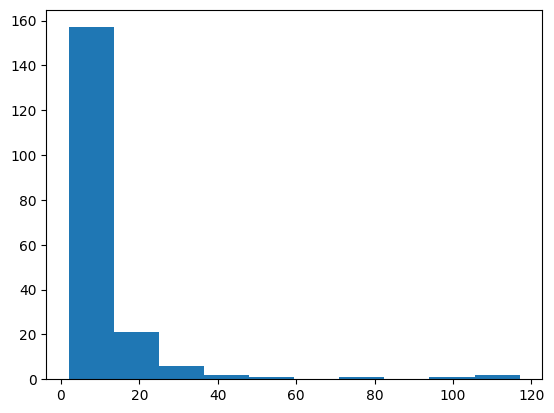

In [ ]:
plt.hist(labels)

STATISTICS ON STORMS

In [ ]:
def visualise_biggest(df, n_biggest):

    nb_reports = pd.DataFrame(df['LABELS'].value_counts()).reset_index()
    nb_reports = nb_reports[nb_reports['index'] != -1].sort_values('LABELS', ascending=False).reset_index()
    labels_biggest_storms = list(nb_reports.iloc[0:3,1])
    df_biggest = df.loc[df.LABELS.isin(labels_biggest_storms)]

    # plots the n_biggest storms 
    plt.figure(figsize=(10,6))
    for i in range(n_biggest):
        a = df_biggest.LONGITUDE[df_biggest.LABELS == labels_biggest_storms[i]]
        b = df_biggest.LATITUDE[df_biggest.LABELS == labels_biggest_storms[i]]
        lab = df_biggest.loc[df_biggest.LABELS == labels_biggest_storms[i]]
        plt.scatter(a, b, c='C{}'.format(i), label='{} most reported storm'.format(i+1))
    plt.ylabel('latitude')
    plt.xlabel('longitude')
    plt.legend()
    plt.title("The {} biggest storms in terms of report counts".format(len(labels_biggest_storms)))
    plt.show()

    # plot timing of storms in latlon
    for i in range(n_biggest):
        x = df_biggest.LONGITUDE[df_biggest.LABELS == labels_biggest_storms[i]]
        y = df_biggest.LATITUDE[df_biggest.LABELS == labels_biggest_storms[i]]
        z = df_biggest.TIME_EVENT[df_biggest.LABELS == labels_biggest_storms[i]]
        z = z - z.iloc[-1]
        x = x.array
        y = y.array
        z = z.array
        axis = plt.subplot(111, title="Storm with {} reports".format(len(x)))
        sc = axis.scatter(x, y, c=z, marker=".")
        plt.colorbar(sc, label="duration of the storm (in hours)")
        plt.show()
        # distance between first and last reports
        df_distance = df_biggest[df_biggest.LABELS==labels_biggest_storms[i]].sort_values('TIME_EVENT')
        df_distance = df_distance.reset_index(drop=True)
        latbegin = df_distance.LATITUDE[0]
        latend = df_distance.LATITUDE[len(df_distance.LATITUDE)-1]
        lonbegin = df_distance.LONGITUDE[0]
        lonend = df_distance.LONGITUDE[len(df_distance.LONGITUDE)-1]
        coords_1 = (latbegin, lonbegin)
        coords_2 = (latend, lonend)
        dist = geopy.distance.geodesic(coords_1, coords_2).km
        print("The storm has length",dist,"km between first report and last report")


    return df

- find density of population in by calculating distance between center of city and report

- actually find density by looking for forests, lakes, green areas.
https://www.observatoire-des-territoires.gouv.fr/outils/cartographie-interactive/#bbox=-784563,6413889,2061226,1124816&c=indicator&i=grid.gridens&view=map36 
https://www.data.gouv.fr/fr/datasets/communes-de-france-base-des-codes-postaux/#resources 

https://www.observatoire-des-territoires.gouv.fr/densite-de-population

- regression : prob reported given density
- find coeff : if density is x then prob of report is y
- create sub groups and reg for each subgroup: departements touche 1 fois, departements touche 2-3 fois, departements touche plus de 3 fois dans l'annee
- recuperer les coefficients du logit
- pour chaque orage, pour des bornes spatio temp, 

- reg prob affected = lat lon time
- prob of affected for each commune

In [ ]:
communes_latlon = pd.read_csv("C:/Users/t480/statappradar/communes-departement-region latlon.csv")

In [ ]:
communes_densite = pd.read_excel("C:/Users/t480/statappradar/densite communes.xlsx")

In [ ]:
communes_latlon

,code_commune_INSEE,nom_commune_postal,code_postal,libelle_acheminement,ligne_5,latitude,longitude,code_commune,article,nom_commune,nom_commune_complet,code_departement,nom_departement,code_region,nom_region
0,1001,L ABERGEMENT CLEMENCIAT,1400,L ABERGEMENT CLEMENCIAT,NaN,46.153426,4.926114,1.0,L',Abergement-Clémenciat,L'Abergement-Clémenciat,1,Ain,84.0,Auvergne-Rhône-Alpes
1,1002,L ABERGEMENT DE VAREY,1640,L ABERGEMENT DE VAREY,NaN,46.009188,5.428017,2.0,L',Abergement-de-Varey,L'Abergement-de-Varey,1,Ain,84.0,Auvergne-Rhône-Alpes
2,1004,AMBERIEU EN BUGEY,1500,AMBERIEU EN BUGEY,NaN,45.960848,5.372926,4.0,NaN,Ambérieu-en-Bugey,Ambérieu-en-Bugey,1,Ain,84.0,Auvergne-Rhône-Alpes
3,1005,AMBERIEUX EN DOMBES,1330,AMBERIEUX EN DOMBES,NaN,45.996180,4.912273,5.0,NaN,Ambérieux-en-Dombes,Ambérieux-en-Dombes,1,Ain,84.0,Auvergne-Rhône-Alpes
4,1006,AMBLEON,1300,AMBLEON,NaN,45.749499,5.594320,6.0,NaN,Ambléon,Ambléon,1,Ain,84.0,Auvergne-Rhône-Alpes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39196,98831,VOH,98883,OUACO,VOH,NaN,NaN,831.0,NaN,Voh,Voh,98,NaN,NaN,NaN
39197,98832,YATE,98834,YATE,NaN,NaN,NaN,832.0,NaN,Yate,Yate,98,NaN,NaN,NaN
39198,98833,KOUAOUA,98818,KOUAOUA,NaN,NaN,NaN,833.0,NaN,Kouaoua,Kouaoua,98,NaN,NaN,NaN
39199,98901,ILE DE CLIPPERTON,98799,ILE DE CLIPPERTON,NaN,NaN,NaN,901.0,NaN,Ile de clipperton,Ile de clipperton,98,NaN,NaN,NaN


In [ ]:
communes_latlon = communes_latlon[['code_commune_INSEE','nom_commune_complet','latitude','longitude']]
communes_latlon = communes_latlon.dropna()
communes_latlon = communes_latlon[~communes_latlon.code_commune_INSEE.str.startswith('97')]
communes_latlon = communes_latlon[~communes_latlon.code_commune_INSEE.str.startswith('2A')]
communes_latlon = communes_latlon[~communes_latlon.code_commune_INSEE.str.startswith('2B')]
communes_latlon['code_commune_INSEE'] = pd.to_numeric(communes_latlon['code_commune_INSEE'])
#communes_latlon['code_commune_INSEE'] = communes_latlon['code_commune_INSEE'].astype(int)
communes_latlon = communes_latlon.rename(columns = {'nom_commune_complet':'Libellé'})
communes_latlon

,code_commune_INSEE,Libellé,latitude,longitude
0,1001,L'Abergement-Clémenciat,46.153426,4.926114
1,1002,L'Abergement-de-Varey,46.009188,5.428017
2,1004,Ambérieu-en-Bugey,45.960848,5.372926
3,1005,Ambérieux-en-Dombes,45.996180,4.912273
4,1006,Ambléon,45.749499,5.594320
...,...,...,...,...
38720,95676,Villers-en-Arthies,49.085900,1.730396
38721,95678,Villiers-Adam,49.070289,2.239509
38722,95680,Villiers-le-Bel,49.008449,2.403856
38723,95682,Villiers-le-Sec,49.074309,2.386890


In [ ]:
type(communes_latlon.iloc[0,0])

numpy.int64

In [ ]:
communes_densite

,Code,Libellé,Grille communale de densité
0,01001,L'Abergement-Clémenciat,3 - Espaces peu denses
1,01002,L'Abergement-de-Varey,4 - Espaces très peu denses
2,01004,Ambérieu-en-Bugey,2 - Espaces de densité intermédiaire
3,01005,Ambérieux-en-Dombes,3 - Espaces peu denses
4,01006,Ambléon,4 - Espaces très peu denses
...,...,...,...
34960,97613,M'Tsangamouji,2 - Espaces de densité intermédiaire
34961,97614,Ouangani,2 - Espaces de densité intermédiaire
34962,97615,Pamandzi,2 - Espaces de densité intermédiaire
34963,97616,Sada,2 - Espaces de densité intermédiaire


In [ ]:
communes_densite = communes_densite[~communes_densite.Code.str.startswith('97')]
communes_densite = communes_densite[~communes_densite.Code.str.startswith('2A')]
communes_densite = communes_densite[~communes_densite.Code.str.startswith('2B')]
communes_densite['Code'] = pd.to_numeric(communes_densite['Code'])
communes_densite = communes_densite.rename(columns = {'Code':'code_commune_INSEE'})
communes_densite


,code_commune_INSEE,Libellé,Grille communale de densité
0,1001,L'Abergement-Clémenciat,3 - Espaces peu denses
1,1002,L'Abergement-de-Varey,4 - Espaces très peu denses
2,1004,Ambérieu-en-Bugey,2 - Espaces de densité intermédiaire
3,1005,Ambérieux-en-Dombes,3 - Espaces peu denses
4,1006,Ambléon,4 - Espaces très peu denses
...,...,...,...
34831,95676,Villers-en-Arthies,3 - Espaces peu denses
34832,95678,Villiers-Adam,2 - Espaces de densité intermédiaire
34833,95680,Villiers-le-Bel,1 - Espaces densément peuplés
34834,95682,Villiers-le-Sec,4 - Espaces très peu denses


In [ ]:
dense = pd.read_excel("C:/Users/t480/statappradar/INSEE densite communes float.xlsx")

In [ ]:
dense

,codgeo,libgeo,an,dens_pop
0,01001,L'Abergement-Clémenciat,2018,48.34
1,01002,L'Abergement-de-Varey,2018,27.65
2,01004,Ambérieu-en-Bugey,2018,577.40
3,01005,Ambérieux-en-Dombes,2018,108.04
4,01006,Ambléon,2018,19.05
...,...,...,...,...
34960,97613,M'Tsangamouji,2018,NaN
34961,97614,Ouangani,2018,NaN
34962,97615,Pamandzi,2018,NaN
34963,97616,Sada,2018,NaN


In [ ]:
dense = dense[['codgeo','libgeo','dens_pop']]
dense = dense[~dense.codgeo.str.startswith('97')]
dense = dense[~dense.codgeo.str.startswith('2A')]
dense = dense[~dense.codgeo.str.startswith('2B')]
dense['codgeo'] = pd.to_numeric(dense['codgeo'])
dense = dense.rename(columns = {'codgeo':'code_commune_INSEE'})
dense


,code_commune_INSEE,libgeo,dens_pop
0,1001,L'Abergement-Clémenciat,48.34
1,1002,L'Abergement-de-Varey,27.65
2,1004,Ambérieu-en-Bugey,577.40
3,1005,Ambérieux-en-Dombes,108.04
4,1006,Ambléon,19.05
...,...,...,...
34831,95676,Villers-en-Arthies,60.24
34832,95678,Villiers-Adam,87.68
34833,95680,Villiers-le-Bel,3841.23
34834,95682,Villiers-le-Sec,57.36


In [ ]:
communes = pd.merge(communes_latlon, dense,how='inner', on='code_commune_INSEE')
communes = communes.drop(columns=['libgeo'])
communes = communes.rename(columns = {'Libellé':'PLACE'})
communes = communes.drop_duplicates()
#communes['PLACE'].value_counts().head(15)
#communes.loc[communes['PLACE'] == "Livarot-Pays-d'Auge", :]
communes


,code_commune_INSEE,PLACE,latitude,longitude,dens_pop
0,1001,L'Abergement-Clémenciat,46.153426,4.926114,48.34
1,1002,L'Abergement-de-Varey,46.009188,5.428017,27.65
2,1004,Ambérieu-en-Bugey,45.960848,5.372926,577.40
3,1005,Ambérieux-en-Dombes,45.996180,4.912273,108.04
4,1006,Ambléon,45.749499,5.594320,19.05
...,...,...,...,...,...
37266,95676,Villers-en-Arthies,49.085900,1.730396,60.24
37267,95678,Villiers-Adam,49.070289,2.239509,87.68
37268,95680,Villiers-le-Bel,49.008449,2.403856,3841.23
37269,95682,Villiers-le-Sec,49.074309,2.386890,57.36


In [ ]:
communes.to_csv("C:/Users/t480/statappradar/communes.csv")

Preparing data for the logistic regression

In [ ]:
data = pd.read_csv("C:/Users/t480/statappradar/eswd_reports_europe_1970_2022.csv")

C:\Users\t480\AppData\Local\Temp\ipykernel_20336\721562798.py:1: DtypeWarning: Columns (18,22,23,24,50,51,77,78,79,85,88) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("C:/Users/t480/statappradar/eswd_reports_europe_1970_2022.csv")


In [ ]:
df=data.drop(['CONTACT','EMAIL', 'ORGANISATION', 'ORGANISATION_ID','CREATOR_ID','REVISOR_ID','PERSON_REVISION','PLACE_LOCAL_LANGUAGE','OROGRAPHY','SURFACE_INITIAL_LOCATION','SURFACE_CROSSED','NO_OBJECTS','EXT_URL','LINK_ORG','LINK_ID','DELETED','F_SCALE','T_SCALE','RATING_BASIS','WIND_SPEED','TEN_MIN_WIND_SPEED','FUNNEL_SIGHTED'  ,'SUCTION_VORTICES' ,'PRECIPITATION_AMOUNT','SNOW_FALL_AMOUNT','PEAK_PRECIP_AMOUNT','PEAK_SNOW_FALL_AMOUNT','PEAK_PRECIP_PERIOD','MAX_6_HOUR_PRECIP','MAX_6_HOUR_SNOW_FALL','MAX_12_HOUR_PRECIP','MAX_12_HOUR_SNOW_FALL','MAX_24_HOUR_PRECIP' ,'MAX_24_HOUR_SNOW_FALL','TYPE_PRECIP','SIZE_ACCOMPANYING_HAIL','POSSIBILITIES','PATH_LENGTH','MEAN_PATH_WIDTH','MAX_PATH_WIDTH','MAX_VERTICAL_DEVELOP','DIRECTION_MOVEMENT','SNOW_HAZARDS','MEAN_HEIGHT_SNOW_CORNICES','MAX_HEIGHT_SNOW_CORNICES','ICE_HAZARDS','THICKNESS_ICE_COVER','THICKNESS_RIME_COVER','AVALANCHE_TYPE','AVALANCHE_FLOW_TYPE','SNOW_MASS_TYPE','AVALANCHE_SIZE','AVALANCHE_TRIGGER','ELEVATION_START','ELEVATION_DIFFERENCE','LIGHTNING_DAMAGE_TO','PEAK_CURRENT','POLARITY','TIME_CREATION','TIME_LAST_REVISION','DETAILED_LOCATION','MAX_HAILSTONE_WEIGHT','CONVECTIVE','PATH_START_LATITUDE','PATH_START_LONGITUDE','PATH_START_DATETIME','PATH_END_LATITUDE','PATH_END_LONGITUDE','PATH_END_DATETIME'],axis=1)

# function allowing us to extract the year from the date of the event
def get_year(donnee):
    date=donnee['TIME_EVENT']
    dt=datetime.strptime(date,'%Y-%m-%d %H:%M:%S')
    dt=dt.year
    return dt

# creation of a column containing the year of the event
df['YEAR']=df.apply(lambda donnee: get_year(donnee), axis=1)

# deleting data prior to 2007 
df.drop(df[df.YEAR < 2007].index, inplace=True)

# function allowing us to extract the month from the date of the event
def get_month(donnee):
    date=donnee['TIME_EVENT']
    dt=datetime.strptime(date,'%Y-%m-%d %H:%M:%S')
    dt=dt.month
    return dt

# creation of a column containing the month of the event
df['MONTH']=df.apply(lambda donnee: get_month(donnee), axis=1)

# function allowing us to extract the day from the date of the event
def get_day(donnee):
    date=donnee['TIME_EVENT']
    dt=datetime.strptime(date,'%Y-%m-%d %H:%M:%S')
    dt=dt.day
    return dt

# creation of a column containing the month of the event
df['DAY']=df.apply(lambda donnee: get_day(donnee), axis=1)

# function allowing us to extract the hour from the date of the event
def get_hour(donnee):
    date=donnee['TIME_EVENT']
    dt=datetime.strptime(date,'%Y-%m-%d %H:%M:%S')
    dt=dt.hour
    return dt

# creation of a column containing the month of the event
df['HOUR']=df.apply(lambda donnee: get_hour(donnee), axis=1)

#maintaining only the columns needed for our model
df=df.loc[:,['LATITUDE','LONGITUDE','TIME_EVENT','COUNTRY','PLACE', 'YEAR', 'MAX_HAIL_DIAMETER']]
#df=df.loc[:,['LATITUDE','LONGITUDE','TIME_EVENT','COUNTRY','YEAR', 'MONTH', 'HOUR','PLACE', 'MAX_HAIL_DIAMETER']]

# delete data prior to 2013 
#(radar data provided to us only start from 2013, we wont be able to confront data prior to that year)
df.drop(df[df.YEAR < 2013].index, inplace=True)
df=df.loc[:,['LATITUDE','LONGITUDE','TIME_EVENT','COUNTRY','PLACE', 'MAX_HAIL_DIAMETER']]

# selecting France and converting to timestamps
df = convert_time_to_timestamps(df)
df = df.reset_index(drop=True)
country = 'FR'
df = df[df['COUNTRY'] == country]

# filtering on mainland France
#print(df_mainland_fr.LATITUDE.max(), df_mainland_fr.LATITUDE.min(), df_mainland_fr.LONGITUDE.max(), df_mainland_fr.LONGITUDE.min(),
# communes.latitude.max(), communes.latitude.min(), communes.longitude.max(), communes.longitude.min())
df.drop(df[df.LATITUDE > communes.latitude.max()].index, inplace=True)
df.drop(df[df.LATITUDE < communes.latitude.min()].index, inplace=True)
df.drop(df[df.LONGITUDE > communes.longitude.max()].index, inplace=True)
df.drop(df[df.LONGITUDE < communes.longitude.min()].index, inplace=True)

nom=ArcGIS()
nom.geocode("Monaco") 
#43.73170451200008, 7.424355000000048
df = df.drop(df[(df.LATITUDE < 43.73170451200008) & (df.LONGITUDE > 7.424355000000048)].index)

df_mainland_fr = df 
df_mainland_fr

df_density = communes.loc[:,['dens_pop','PLACE']]
df_mainland_fr = pd.merge(df_mainland_fr, df_density,how='inner', on='PLACE')
print(df_mainland_fr.LATITUDE.max(), df_mainland_fr.LATITUDE.min(), df_mainland_fr.LONGITUDE.max(), df_mainland_fr.LONGITUDE.min(),
 communes.latitude.max(), communes.latitude.min(), communes.longitude.max(), communes.longitude.min())

df_dbscan = df_mainland_fr[['TIME_EVENT', 'LATITUDE', 'LONGITUDE']]
df_dbscan = df_dbscan.reset_index(drop=True)
df_dbscan = run_dbscan_retrieve_classes(df_dbscan, 0.16, 1, 2)
df_mainland_fr['LABEL'] = df_dbscan.loc[:,'LABELS']

dfreg = df_mainland_fr[df_mainland_fr.LABEL > -1]
dfreg = dfreg.drop(columns=['COUNTRY','PLACE'])

dummies = pd.get_dummies(dfreg['LABEL'])
dummies
dfreg = dfreg.join(dummies)

dfreg

51.05 42.433 8.133 -3.95 51.0730436867 42.3559782284 8.18637725776 -5.08534533544


,LATITUDE,LONGITUDE,TIME_EVENT,MAX_HAIL_DIAMETER,dens_pop,LABEL,0,1,2,3,...,411,412,413,414,415,416,417,418,419,420
0,45.567,5.933,462946.250000,2.0,2802.91,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,45.567,5.933,452126.750000,2.0,2802.91,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,45.596,5.875,462945.866667,2.0,399.73,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,49.583,1.358,462928.500000,4.5,27.09,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,49.583,1.358,462928.500000,4.5,107.41,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3230,47.284,2.954,380728.000000,NaN,79.93,419,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3232,47.317,2.967,380728.000000,NaN,27.03,419,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3234,47.983,6.750,379861.250000,2.0,63.15,420,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3235,47.933,6.667,379861.083333,4.0,77.45,420,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
dfreg.LABEL.value_counts()

68     100
141     85
11      75
90      70
144     56
      ... 
247      2
248      2
252      2
255      2
420      2
Name: LABEL, Length: 421, dtype: int64

In [ ]:
dfreg.MAX_HAIL_DIAMETER.count()/dfreg.shape[0]

0.7933358292774242

LOGISTIC REGRESSION

In [ ]:
# first regression with Max hail diameter but removing NAN

df_max_hail = dfreg.dropna()

y = df_max_hail.loc[:,68]
x = df_max_hail[["LATITUDE","LONGITUDE","TIME_EVENT","dens_pop","MAX_HAIL_DIAMETER"]]
x

# on ajoute une colonne pour la constante
x_stat = sm.add_constant(x)
# on ajuste le modèle
model = sm.Logit(y, x_stat)
result = model.fit()

result.summary()

Optimization terminated successfully.
         Current function value: inf
         Iterations 14


c:\Users\t480\.pyenv\pyenv-win\versions\3.10.0\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\t480\.pyenv\pyenv-win\versions\3.10.0\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
c:\Users\t480\.pyenv\pyenv-win\versions\3.10.0\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\Users\t480\.pyenv\pyenv-win\versions\3.10.0\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     68   No. Observations:                 2119
Model:                          Logit   Df Residuals:                     2113
Method:                           MLE   Df Model:                            5
Date:                Mon, 30 Jan 2023   Pseudo R-squ.:                     inf
Time:                        17:21:20   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -335.9302     47.843     -7.022      0.000    -429.700    -242.160
LATITUDE              4.6783      0.550      8.505      0.000       3.600       5.756
LONGITUDE             3.6913      0.495      7.454      0.000       2.721       4.662
TIME_EVENT            0.0002   7.68e-05      2.301      0.021    2.62e-05       0.000
dens_pop             -0.0005      0.000     -1.266      0.206      -0.001       0.000
MAX_HAIL_DIAMETER     0.6968      0.188      3.710      0.000       0.329       1.065
=====================================================================================

Possibly complete quasi-separation: A fraction 0.80 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [ ]:
# first regression without Max hail diameter so more obs

df_no_max_hail = dfreg.copy()

y = df_no_max_hail.loc[:,68]
x = df_no_max_hail[["LATITUDE","LONGITUDE","TIME_EVENT","dens_pop"]]
x

# on ajoute une colonne pour la constante
x_stat = sm.add_constant(x)
# on ajuste le modèle
model = sm.Logit(y, x_stat)
result = model.fit()

result.summary()

Optimization terminated successfully.
         Current function value: inf
         Iterations 16


c:\Users\t480\.pyenv\pyenv-win\versions\3.10.0\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\t480\.pyenv\pyenv-win\versions\3.10.0\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
c:\Users\t480\.pyenv\pyenv-win\versions\3.10.0\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\Users\t480\.pyenv\pyenv-win\versions\3.10.0\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     68   No. Observations:                 2671
Model:                          Logit   Df Residuals:                     2666
Method:                           MLE   Df Model:                            4
Date:                Mon, 30 Jan 2023   Pseudo R-squ.:                     inf
Time:                        17:22:32   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -393.4857     96.975     -4.058      0.000    -583.553    -203.419
LATITUDE       4.2256      0.528      8.008      0.000       3.191       5.260
LONGITUDE      3.2135      0.416      7.731      0.000       2.399       4.028
TIME_EVENT     0.0004      0.000      1.911      0.056   -9.24e-06       0.001
dens_pop      -0.0003      0.000     -0.800      0.424      -0.001       0.000
==============================================================================

Possibly complete quasi-separation: A fraction 0.83 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [ ]:
# most reported storms (imbalanced data)

dfreg['LABEL'].value_counts()/df.shape[0]


68     0.031496
141    0.026772
11     0.023622
90     0.022047
144    0.017638
         ...   
247    0.000630
248    0.000630
252    0.000630
255    0.000630
420    0.000630
Name: LABEL, Length: 421, dtype: float64

<AxesSubplot: xlabel='LONGITUDE', ylabel='LATITUDE'>

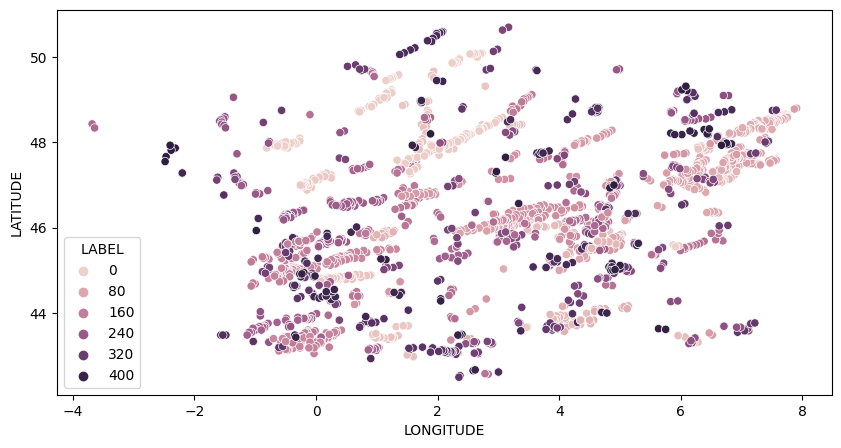

In [ ]:
# scatter plot
plt.figure(figsize=(10,5))
sns.scatterplot(data=dfreg,x='LONGITUDE',y='LATITUDE',hue='LABEL')

In [ ]:
# split dataset into x,y
df_max_hail = dfreg.dropna()
y = df_max_hail.loc[:,68]
x = df_max_hail[["LATITUDE","LONGITUDE","TIME_EVENT","dens_pop","MAX_HAIL_DIAMETER"]]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=13)

In [ ]:
# define model
lg1 = LogisticRegression(random_state=13, class_weight=None)
# fit it
lg1.fit(X_train,y_train)
# test
y_pred = lg1.predict(X_test)
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')

Accuracy Score: 0.9544025157232704
Confusion Matrix: 
[[607   0]
 [ 29   0]]
Area Under Curve: 0.5
Recall score: 0.0


In [ ]:
# define class weights
w = {0:1, 1:99}
# define model
lg2 = LogisticRegression(random_state=13, class_weight=w)
# fit it
lg2.fit(X_train,y_train)
# test
y_pred = lg2.predict(X_test)
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')

Accuracy Score: 0.8647798742138365
Confusion Matrix: 
[[521  86]
 [  0  29]]
Area Under Curve: 0.929159802306425
Recall score: 1.0


In [ ]:
# define weight hyperparameter
w = [{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
     {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
     {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
     {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
     {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
     {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]
hyperparam_grid = {"class_weight": w }

In [ ]:
# define model
lg3 = LogisticRegression(random_state=13)
# define evaluation procedure
grid = GridSearchCV(lg3,hyperparam_grid,scoring="roc_auc", cv=100, n_jobs=-1, refit=True)
grid.fit(x,y)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.8251428571428572 with param: {'class_weight': {0: 1.0, 1: 99}}


In [ ]:
# define model
lg3 = LogisticRegression(random_state=13, class_weight={0: 1.0, 1: 99})
# fit it
lg3.fit(X_train,y_train)
# test
y_pred = lg3.predict(X_test)
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')

Accuracy Score: 0.8647798742138365
Confusion Matrix: 
[[521  86]
 [  0  29]]
Area Under Curve: 0.929159802306425
Recall score: 1.0


In [ ]:
# define hyperparameters
w = [{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
     {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
     {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
     {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
     {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
     {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]
crange = np.arange(0.5, 20.0, 0.5)
hyperparam_grid = {"class_weight": w
                   ,"penalty": ["l1", "l2"]
                   ,"C": crange
                   ,"fit_intercept": [True, False]  }

In [ ]:
# logistic model classifier
lg4 = LogisticRegression(random_state=13)
# define evaluation procedure
grid = GridSearchCV(lg4,hyperparam_grid,scoring="roc_auc", cv=50, n_jobs=-1, refit=True)
grid.fit(x,y)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

c:\Users\t480\.pyenv\pyenv-win\versions\3.10.0\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
136500 fits failed out of a total of 273000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
136500 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\t480\.pyenv\pyenv-win\versions\3.10.0\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\t480\.pyenv\pyenv-win\versions\3.10.0\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\t480\.pyenv\pyenv-win\versions\3.10.0\lib\sit

Best score: 0.8275182926829268 with param: {'C': 1.5, 'class_weight': {0: 1.0, 1: 99}, 'fit_intercept': True, 'penalty': 'l2'}


c:\Users\t480\.pyenv\pyenv-win\versions\3.10.0\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [       nan 0.66153659        nan ... 0.7567378         nan 0.7567378 ]
  warnings.warn(


In [ ]:
# define model
lg4 = LogisticRegression(random_state=13,C=1.5,fit_intercept=True, penalty='l2',class_weight={0: 1.0, 1: 99})
# fit it
lg4.fit(X_train,y_train)
# test
y_pred = lg4.predict(X_test)
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}') # 0.5
print(f'Recall score: {recall_score(y_test,y_pred)}')

NameError: name 'LogisticRegression' is not defined

In [ ]:
# split dataset into x,y
df_max_hail = dfreg.dropna()
y = df_max_hail.loc[:,68]
x = df_max_hail[["LATITUDE","LONGITUDE","TIME_EVENT","dens_pop","MAX_HAIL_DIAMETER"]]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=13)

# define model
lg3 = LogisticRegression(random_state=13, class_weight={0: 1.0, 1: 99})
# fit it
lg3.fit(X_train,y_train)
# test
y_pred = lg3.predict(X_test)
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')

Accuracy Score: 0.8647798742138365
Confusion Matrix: 
[[521  86]
 [  0  29]]
Area Under Curve: 0.929159802306425
Recall score: 1.0


In [ ]:
def logit_pred(dfreg, which_cluster):

    """
    Most report storms and proportion of total sample are
    68     0.031496
    141    0.026772
    11     0.023622
    90     0.022047
    144    0.017638
    """

    #data, using max hail diameter but to be replaced by radar
    df_max_hail = dfreg.dropna()
    y = df_max_hail.loc[:,which_cluster]
    x = df_max_hail[["LATITUDE","LONGITUDE","TIME_EVENT","dens_pop","MAX_HAIL_DIAMETER"]]
    x

    # define weight hyperparameter
    w = [{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
        {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
        {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
        {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
        {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
        {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
        {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
        {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
        {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
        {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]
    hyperparam_grid = {"class_weight": w }

    # define model
    lg3 = LogisticRegression(random_state=13)
    # define evaluation procedure
    grid = GridSearchCV(lg3,hyperparam_grid,scoring="roc_auc", cv=100, n_jobs=-1, refit=True)
    grid.fit(x,y)
    print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

    # confusion matrix of train-test
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=13)

    # define model
    lg3 = LogisticRegression(random_state=13, class_weight={0: 1.0, 1: 99})
    # fit it
    lg3.fit(X_train,y_train)
    # test
    y_pred = lg3.predict(X_test)
    # performance
    print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
    print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
    print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
    print(f'Recall score: {recall_score(y_test,y_pred)}')

    # bin reports to predict if they belong to the current cluster
    dflogit = df_mainland_fr.copy()
    dflogit = dflogit.drop(columns=['COUNTRY','PLACE'])
    dflogit = dflogit[dflogit["LABEL"]==-1]
    dflogit = dflogit.dropna()
    x_test = dflogit[["LATITUDE","LONGITUDE","TIME_EVENT","dens_pop","MAX_HAIL_DIAMETER"]]

    # define model
    logit = LogisticRegression(random_state=13, class_weight= grid.best_params_['class_weight'])
    # fit it
    logit.fit(x,y)
    # test
    y_pred = logit.predict(x_test)

    # proportion of bin cluster assigned to biggest cluster
    prop_bin_to_cluster = y_pred.sum()/y_pred.shape[0]
    print("The proportion of the bin cluster assigned to cluster:",prop_bin_to_cluster)


    dflogit["y_pred"] = y_pred
    cluster = df_max_hail[df_max_hail["LABEL"]==which_cluster]
    # scatter plot
    plt.figure(figsize=(10,5))
    sns.scatterplot(data=dflogit,x='LONGITUDE',y='LATITUDE',hue='y_pred')
    sns.scatterplot(data=cluster,x='LONGITUDE',y='LATITUDE',hue='LABEL')

    return dflogit, cluster


Best score: 0.8251428571428572 with param: {'class_weight': {0: 1.0, 1: 99}}
Accuracy Score: 0.8647798742138365
Confusion Matrix: 
[[521  86]
 [  0  29]]
Area Under Curve: 0.929159802306425
Recall score: 1.0
The proportion of the bin cluster assigned to cluster: 0.14049586776859505


(      LATITUDE  LONGITUDE     TIME_EVENT  MAX_HAIL_DIAMETER  dens_pop  LABEL  \
 6       48.333      1.933  462926.783333                7.0    144.14     -1   
 33      49.900      2.300  398197.666667                2.0   2707.06     -1   
 39      49.502      1.586  462927.050000                3.0     18.23     -1   
 42      48.500      0.483  462926.500000                2.5     25.59     -1   
 58      48.183     -0.892  462924.166667                2.0     70.29     -1   
 ...        ...        ...            ...                ...       ...    ...   
 3221    48.133      2.750  380955.000000                5.0    138.19     -1   
 3224    46.467     -0.817  380953.000000                3.0    390.66     -1   
 3226    48.083      0.667  380953.000000                4.0     33.32     -1   
 3229    45.917     -0.800  380952.833333                3.5     33.78     -1   
 3237    47.850      3.967  379827.000000                2.0     76.85     -1   
 
       y_pred  
 6        

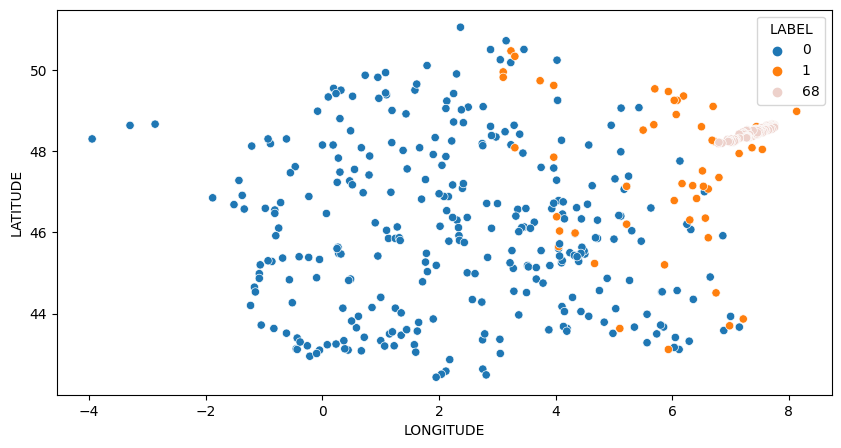

In [ ]:
logit_pred(dfreg,68)

c:\Users\t480\.pyenv\pyenv-win\versions\3.10.0\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 75 members, which is less than n_splits=100.
  warnings.warn(
c:\Users\t480\.pyenv\pyenv-win\versions\3.10.0\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best score: nan with param: {'class_weight': {0: 1000, 1: 100}}
Accuracy Score: 0.0330188679245283
Confusion Matrix: 
[[  0 615]
 [  0  21]]
Area Under Curve: 0.5
Recall score: 1.0
The proportion of the bin cluster assigned to cluster: 0.0


(      LATITUDE  LONGITUDE     TIME_EVENT  MAX_HAIL_DIAMETER  dens_pop  LABEL  \
 6       48.333      1.933  462926.783333                7.0    144.14     -1   
 33      49.900      2.300  398197.666667                2.0   2707.06     -1   
 39      49.502      1.586  462927.050000                3.0     18.23     -1   
 42      48.500      0.483  462926.500000                2.5     25.59     -1   
 58      48.183     -0.892  462924.166667                2.0     70.29     -1   
 ...        ...        ...            ...                ...       ...    ...   
 3221    48.133      2.750  380955.000000                5.0    138.19     -1   
 3224    46.467     -0.817  380953.000000                3.0    390.66     -1   
 3226    48.083      0.667  380953.000000                4.0     33.32     -1   
 3229    45.917     -0.800  380952.833333                3.5     33.78     -1   
 3237    47.850      3.967  379827.000000                2.0     76.85     -1   
 
       y_pred  
 6        

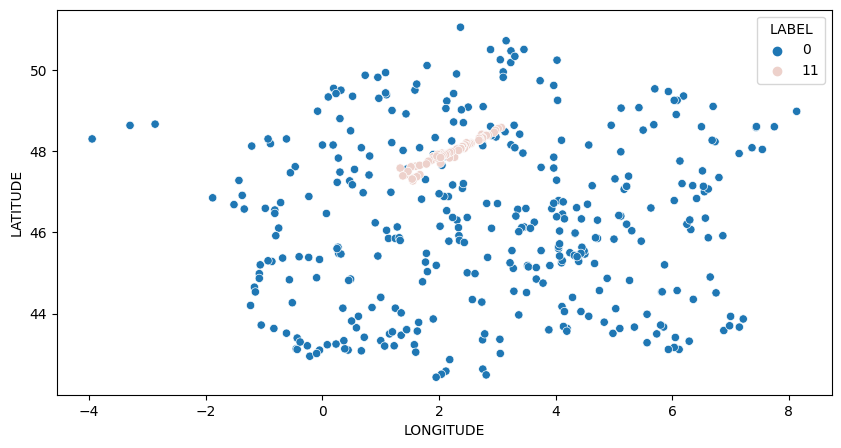

In [ ]:
logit_pred(dfreg,11)

In [ ]:
# now without max hail diameter

def logit_pred_noNA(dfreg, which_cluster):

    """
    Most report storms and proportion of total sample are
    68     0.031496
    141    0.026772
    11     0.023622
    90     0.022047
    144    0.017638
    """

    #data, NOT using max hail diameter but to be replaced by radar
    
    df_no_max_hail = dfreg.copy()
    y = df_no_max_hail.loc[:,which_cluster]
    x = df_no_max_hail[["LATITUDE","LONGITUDE","TIME_EVENT","dens_pop"]]
    x

    # define weight hyperparameter
    w = [{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
        {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
        {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
        {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
        {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
        {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
        {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
        {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
        {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
        {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]
    hyperparam_grid = {"class_weight": w }

    # define model
    lg3 = LogisticRegression(random_state=13)
    # define evaluation procedure
    grid = GridSearchCV(lg3,hyperparam_grid,scoring="roc_auc", cv=100, n_jobs=-1, refit=True)
    grid.fit(x,y)
    print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

    # confusion matrix of train-test
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=13)

    # define model
    lg3 = LogisticRegression(random_state=13, class_weight={0: 1.0, 1: 99})
    # fit it
    lg3.fit(X_train,y_train)
    # test
    y_pred = lg3.predict(X_test)
    # performance
    print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
    print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
    print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
    print(f'Recall score: {recall_score(y_test,y_pred)}')

    # bin reports to predict if they belong to the current cluster
    dflogit = df_mainland_fr.copy()
    dflogit = dflogit.drop(columns=['COUNTRY','PLACE'])
    dflogit = dflogit[dflogit["LABEL"]==-1]
    dflogit = dflogit.dropna()
    x_test = dflogit[["LATITUDE","LONGITUDE","TIME_EVENT","dens_pop"]]

    # define model
    logit = LogisticRegression(random_state=13, class_weight= grid.best_params_['class_weight'])
    # fit it
    logit.fit(x,y)
    # test
    y_pred = logit.predict(x_test)

    # proportion of bin cluster assigned to biggest cluster
    prop_bin_to_cluster = y_pred.sum()/y_pred.shape[0]
    print("The proportion of the bin cluster assigned to cluster:",prop_bin_to_cluster)

    # stats
    predict_proba = logit.predict_proba(x_test) 
    score = logit.score(x,y)
    params = logit.get_params()
    print('The probabilites are:',predict_proba)
    print('Score =',score)
    print('Parameters=',params)

    dflogit["y_pred"] = y_pred
    dflogit["predict_proba"] = predict_proba[:,1]
    cluster = df_max_hail[df_max_hail["LABEL"]==which_cluster]
    # scatter plot
    plt.figure(figsize=(10,5))
    sns.scatterplot(data=dflogit,x='LONGITUDE',y='LATITUDE',hue='y_pred')
    sns.scatterplot(data=cluster,x='LONGITUDE',y='LATITUDE',hue='LABEL')

    return dflogit, cluster


Best score: 0.914676923076923 with param: {'class_weight': {0: 0.01, 1: 1.0}}
Accuracy Score: 0.9039900249376559
Confusion Matrix: 
[[689  77]
 [  0  36]]
Area Under Curve: 0.9497389033942558
Recall score: 1.0
The proportion of the bin cluster assigned to cluster: 0.16804407713498623
The probabilites are: [[9.99815002e-01 1.84997794e-04]
 [8.94676205e-01 1.05323795e-01]
 [9.99840072e-01 1.59928426e-04]
 [9.99990752e-01 9.24830511e-06]
 [9.99999580e-01 4.19720376e-07]
 [9.99996981e-01 3.01891689e-06]
 [5.03745862e-01 4.96254138e-01]
 [4.93709945e-01 5.06290055e-01]
 [9.99999922e-01 7.78113420e-08]
 [9.99956020e-01 4.39799265e-05]
 [9.99839134e-01 1.60866130e-04]
 [9.89923471e-01 1.00765287e-02]
 [9.98753510e-01 1.24648972e-03]
 [9.99996526e-01 3.47427721e-06]
 [9.99999171e-01 8.28580593e-07]
 [9.99999784e-01 2.16288070e-07]
 [9.99569905e-01 4.30094971e-04]
 [9.94217834e-01 5.78216608e-03]
 [9.99862706e-01 1.37293721e-04]
 [9.99461412e-01 5.38587792e-04]
 [9.16774228e-01 8.32257716e-02]


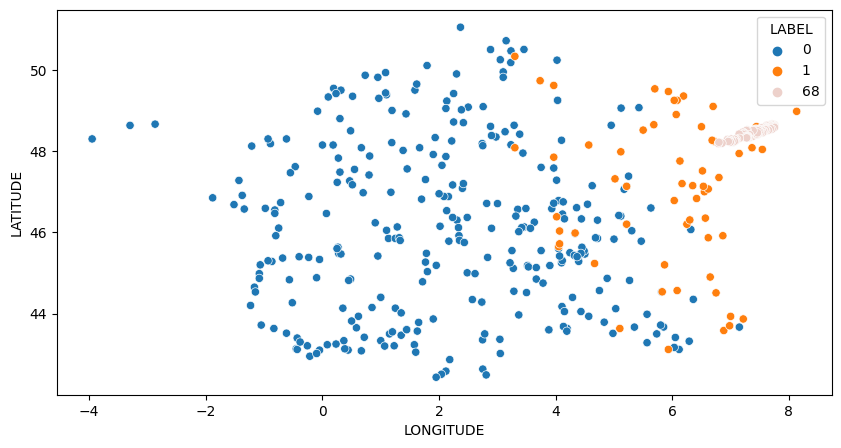

In [ ]:
dflogit, cluster = logit_pred_noNA(dfreg, 68) # also plot threshold 

In [ ]:
dflogit

,LATITUDE,LONGITUDE,TIME_EVENT,MAX_HAIL_DIAMETER,dens_pop,LABEL,y_pred,predict_proba
6,48.333,1.933,462926.783333,7.0,144.14,-1,0,1.849978e-04
33,49.900,2.300,398197.666667,2.0,2707.06,-1,0,1.053238e-01
39,49.502,1.586,462927.050000,3.0,18.23,-1,0,1.599284e-04
42,48.500,0.483,462926.500000,2.5,25.59,-1,0,9.248305e-06
58,48.183,-0.892,462924.166667,2.0,70.29,-1,0,4.197204e-07
...,...,...,...,...,...,...,...,...
3221,48.133,2.750,380955.000000,5.0,138.19,-1,0,3.904540e-01
3224,46.467,-0.817,380953.000000,3.0,390.66,-1,0,1.361568e-04
3226,48.083,0.667,380953.000000,4.0,33.32,-1,0,7.392440e-03
3229,45.917,-0.800,380952.833333,3.5,33.78,-1,0,1.110989e-04


<AxesSubplot: xlabel='predict_proba', ylabel='Count'>

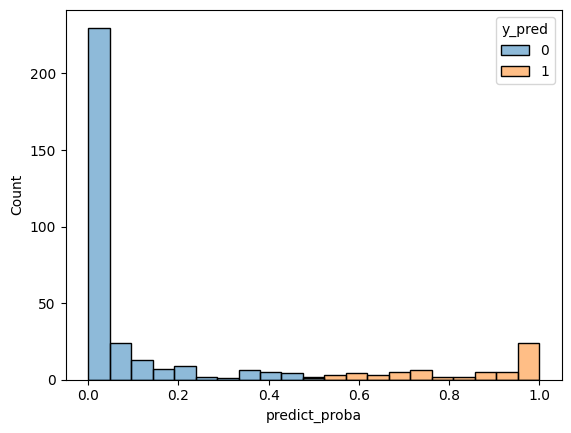

In [ ]:
# threshold at 0.5
sns.histplot(data=dflogit, x="predict_proba", hue='y_pred')

c:\Users\t480\.pyenv\pyenv-win\versions\3.10.0\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 75 members, which is less than n_splits=100.
  warnings.warn(
c:\Users\t480\.pyenv\pyenv-win\versions\3.10.0\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best score: nan with param: {'class_weight': {0: 1000, 1: 100}}
Accuracy Score: 0.028678304239401497
Confusion Matrix: 
[[  0 779]
 [  0  23]]
Area Under Curve: 0.5
Recall score: 1.0
The proportion of the bin cluster assigned to cluster: 0.0


(      LATITUDE  LONGITUDE     TIME_EVENT  MAX_HAIL_DIAMETER  dens_pop  LABEL  \
 6       48.333      1.933  462926.783333                7.0    144.14     -1   
 33      49.900      2.300  398197.666667                2.0   2707.06     -1   
 39      49.502      1.586  462927.050000                3.0     18.23     -1   
 42      48.500      0.483  462926.500000                2.5     25.59     -1   
 58      48.183     -0.892  462924.166667                2.0     70.29     -1   
 ...        ...        ...            ...                ...       ...    ...   
 3221    48.133      2.750  380955.000000                5.0    138.19     -1   
 3224    46.467     -0.817  380953.000000                3.0    390.66     -1   
 3226    48.083      0.667  380953.000000                4.0     33.32     -1   
 3229    45.917     -0.800  380952.833333                3.5     33.78     -1   
 3237    47.850      3.967  379827.000000                2.0     76.85     -1   
 
       y_pred  
 6        

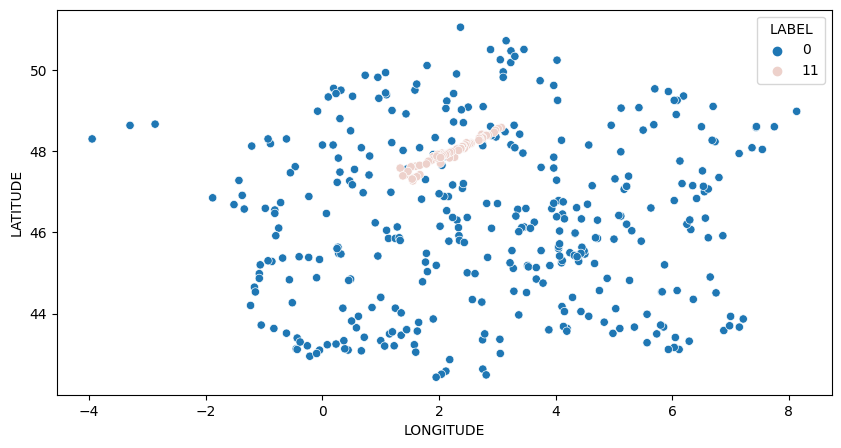

In [ ]:
logit_pred_noNA(dfreg, 11)

need to add explanatory variables

In [ ]:
need to t

other algorithm

In [ ]:
#rf

Multi-class classification with -1 cluster

PLOTTING

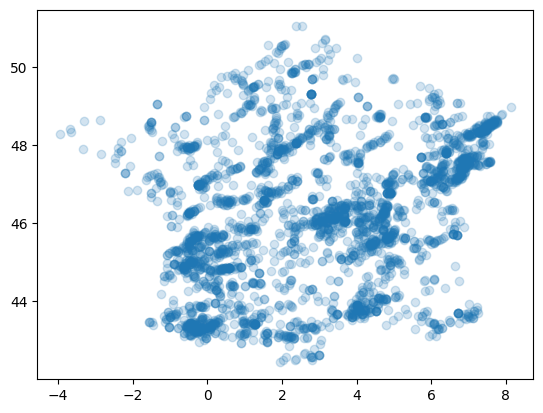

In [ ]:
# plotting reports to guess size of grid
plt.scatter(df_mainland_fr.LONGITUDE, df_mainland_fr.LATITUDE, alpha=0.2)
plt.show()
# go with squares of 0.5 degrees-sides 

In [ ]:
# extending end lon and end lat
latgrid = np.arange(42.433,51.5,0.5)
longrid = np.arange(-3.95,8.6,0.5)
grid_size = latgrid.shape[0]*longrid.shape[0]
print(grid_size)
print(latgrid.shape[0], longrid.shape[0])

494
19 26


In [ ]:
lat_for_grid = df_mainland_fr.loc[:,'LATITUDE']
lon_for_grid = df_mainland_fr.loc[:,'LONGITUDE']
lat_for_grid = pd.qcut(lat_for_grid, 19, labels=np.arange(1,20))
lon_for_grid = pd.qcut(lon_for_grid, 26, labels=np.arange(1,27))
lat_for_grid

0        8
1        8
2        8
3       19
4       19
        ..
3233    16
3234    16
3235    16
3236     6
3237    16
Name: LATITUDE, Length: 3238, dtype: category
Categories (19, int64): [1 < 2 < 3 < 4 ... 16 < 17 < 18 < 19]

In [ ]:
df_mainland_fr['LAT_CAT'] = lat_for_grid
df_mainland_fr['LON_CAT'] = lon_for_grid
df_mainland_fr

,LATITUDE,LONGITUDE,TIME_EVENT,COUNTRY,YEAR,MONTH,HOUR,PLACE,dens_pop,LAT_CAT,LON_CAT
0,45.567,5.933,462946.250000,FR,2022,10,10,Chambéry,2802.91,8,22
1,45.567,5.933,452126.750000,FR,2021,7,14,Chambéry,2802.91,8,22
2,45.596,5.875,462945.866667,FR,2022,10,9,La Motte-Servolex,399.73,8,22
3,49.583,1.358,462928.500000,FR,2022,10,16,Buchy,27.09,19,9
4,49.583,1.358,462928.500000,FR,2022,10,16,Buchy,107.41,19,9
...,...,...,...,...,...,...,...,...,...,...,...
3233,47.917,-3.333,380726.000000,FR,2013,6,14,Plouay,85.04,16,1
3234,47.983,6.750,379861.250000,FR,2013,5,13,Basse-sur-le-Rupt,63.15,16,24
3235,47.933,6.667,379861.083333,FR,2013,5,13,Rupt-sur-Moselle,77.45,16,24
3236,44.883,0.533,379827.500000,FR,2013,5,3,Lembras,110.95,6,7


In [ ]:
df_mainland_fr.to_csv("C:/Users/t480/statappradar/df_mainland_fr.csv")

In [ ]:
# regression options
# y = number of reports in each box
# nb of reports in lat_cat
# report is in cat_lat 0,1
# report is in box 1, box 2, 
# nb reports in each city : first reg y = number in chambery, 

# obj
# predict for communes where we do not have reports the expected number of reports  

In [ ]:
!pip install statsmodels

     ---------------------------------------- 9.1/9.1 MB 2.7 MB/s eta 0:00:00
     -------------------------------------- 233.8/233.8 kB 4.8 MB/s eta 0:00:00


In [ ]:
import statsmodels.api as sm

In [ ]:
df_regression = pd.read_csv("C:/Users/t480/statappradar/df_cluster.csv")
df_regression

,Unnamed: 0.1,Unnamed: 0,LATITUDE,LONGITUDE,TIME_EVENT,COUNTRY,YEAR,MONTH,HOUR,PLACE,dens_pop,LAT_CAT,LON_CAT,LABEL
0,0,0,45.567,5.933,462946.250000,FR,2022,10,10,Chambéry,2802.91,8,22,0
1,1,1,45.567,5.933,452126.750000,FR,2021,7,14,Chambéry,2802.91,8,22,1
2,2,2,45.596,5.875,462945.866667,FR,2022,10,9,La Motte-Servolex,399.73,8,22,0
3,3,3,49.583,1.358,462928.500000,FR,2022,10,16,Buchy,27.09,19,9,2
4,4,4,49.583,1.358,462928.500000,FR,2022,10,16,Buchy,107.41,19,9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3233,3233,3233,47.917,-3.333,380726.000000,FR,2013,6,14,Plouay,85.04,16,1,-1
3234,3234,3234,47.983,6.750,379861.250000,FR,2013,5,13,Basse-sur-le-Rupt,63.15,16,24,420
3235,3235,3235,47.933,6.667,379861.083333,FR,2013,5,13,Rupt-sur-Moselle,77.45,16,24,420
3236,3236,3236,44.883,0.533,379827.500000,FR,2013,5,3,Lembras,110.95,6,7,227


In [ ]:
df_regression = df_regression.drop(columns=['Unnamed: 0.1','Unnamed: 0'])
zeros = np.zeros(df_regression.shape[0])
df_regression[df_regression['LABEL']==68]

In [ ]:
pd.get_dummies(df_regression['LABEL'])

,-1,0,1,2,3,4,5,6,7,8,...,411,412,413,414,415,416,417,418,419,420
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3233,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3234,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3235,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3236,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# on ajoute une colonne pour la constante
x_stat = sm.add_constant(x)
# on ajuste le modèle
model = sm.Logit(y, x_stat)
result = model.fit()

PLOTTING GRID

In [ ]:
np.arange(42.433,55.3,0.5)

(26,)

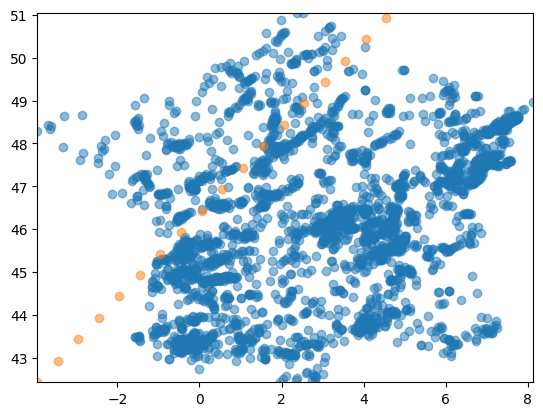

In [ ]:
plt.scatter(df_mainland_fr.LONGITUDE, df_mainland_fr.LATITUDE, alpha=0.5)
plt.xlim(df_mainland_fr.LONGITUDE.min(), df_mainland_fr.LONGITUDE.max())
plt.ylim(df_mainland_fr.LATITUDE.min(), df_mainland_fr.LATITUDE.max())
ax.set_yticks([0.2, 0.6, 0.8], minor=False)
ax.set_yticks([0.3, 0.55, 0.7], minor=True)
plt.show()

In [ ]:
np.random.random((10, 10)).shape

(10, 10)

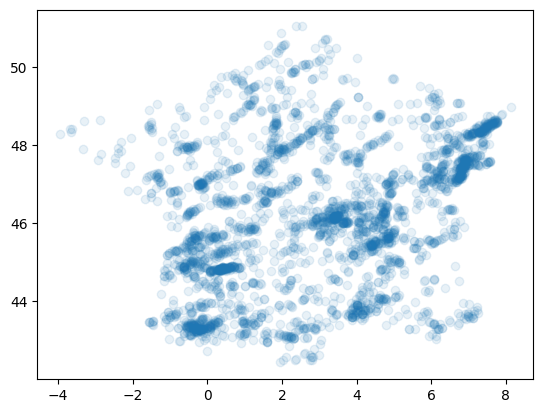

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(df_mainland_fr.LONGITUDE, df_mainland_fr.LATITUDE, alpha=0.1)
plt.show()
